This notebook contains the parent classifier that will divide the data into two categories:

1. Glitch
2. Background

Note that this notebook only trains the model and saves it to a directory.The testing of the model must be done in the file "Model_Evaluation.ipynb"

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

image_size = 128
# Change path and filename as needed given the chosen qtransform parameters 
# This is because the dynamic naming of the images .h5 file will be based 
# on the chosen parameters that generated it, as a way of differentiating each file.
square_image_path = '/content/drive/MyDrive/GW/128x128_003_003_images.h5'


Mounted at /content/drive


In [3]:
# Load in our image dataset (features)
# Note here I only load in glitch and background for memory efficiency
X = np.empty((4096, 2, image_size, image_size))
with h5py.File(square_image_path, 'r') as f:
    X[:2048, 0:2, :, :] = np.array(f['glitch'])
    X[2048:4096, 0:2, :, :] = np.array(f['background'])

# Create our labels 
# 0 = glitch
# 1 = background
binary_labels = [i for i in range(2) for _ in range(2048)]
y = np.array(binary_labels)

print(f'Shape of features: {X.shape}')
print(f'Shape of labels: {y.shape}')


Shape of features: (4096, 2, 128, 128)
Shape of labels: (4096,)


In [4]:
# Split our dataset into train test and validation

# 80% train, 20% test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# To avoid memory issues we can now delete our original array
del X
gc.collect()
# Use 10% of the training set for validation

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Check the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_validation.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_val shape:", y_validation.shape)



X_train shape: (2948, 2, 128, 128)
X_test shape: (820, 2, 128, 128)
X_val shape: (328, 2, 128, 128)
y_train shape: (2948,)
y_test shape: (820,)
y_val shape: (328,)


Create CNN Model Class. 

The model we created is a cnn with 7 layers, and then 3 fully connected layers. 

The model class is written to have a dynamic number of layers, and has a method to calculate the correct number of output features so that there are no issues when transitioning into the fully connected layer.

In [5]:
class myCNNModel(nn.Module):

    def __init__(self, hyper_params):
        super(myCNNModel, self).__init__()
        # Load in relevant hyper_params
        self.hyper_params = hyper_params
        self.current_channel_count = hyper_params['first_layer_output_channels']
        self.max_channels = hyper_params['max_channels']
        self.layers = []
        # Call our cnn builder and calculate the output size
        self._build_cnn_layers(hyper_params)
        self._calculate_output_size()
        # Transition into fully connected layer using the calculated output size
        self.flatten = nn.Flatten()
        # The output size of each fully connected layer is the input size of the following layer
        self.fc1 = nn.Linear(self.output_size, hyper_params['fc_hidden1'])
        self.fc2 = nn.Linear(hyper_params['fc_hidden1'], hyper_params['fc_hidden2'])
        self.fc3 = nn.Linear(hyper_params['fc_hidden2'], hyper_params['out_nodes'])
        self.relu = nn.ReLU()

    def _build_cnn_layers(self, hyper_params):

        current_channel_count = self.current_channel_count
        max_channels = self.max_channels
        counter = 0
        # Call the while loop to build cnn layers that double the number of channels until the specified max amount is reached  
        while current_channel_count < max_channels:
            # Check if this is the first time the loop is being run, if it is set the input channels for this layer to whatever it is in the data
            if counter == 0:
              current_channel_count = self.hyper_params['in_channels']
              next_channel_count = self.hyper_params['first_layer_output_channels']
            # If this is not the first layer, simply double the input channel count
            else:
              # Double the number of channels each time
              next_channel_count = 2 * current_channel_count


            # Apply the 2d convolution since our image is 2 dimensional 
            self.layers.append(nn.Conv2d(in_channels=current_channel_count, out_channels=next_channel_count,
                                         kernel_size=self.hyper_params['conv_kernel_size'], stride=self.hyper_params['conv_stride'], padding=self.hyper_params['conv_padding']))
            # Use batch normalization in each layer to prevent vanishing or exploding gradients 
            self.layers.append(nn.BatchNorm2d(next_channel_count))
            # Use a relu Activation function
            self.layers.append(nn.ReLU())
            # Use max pooling to extract features 
            self.layers.append(nn.MaxPool2d(kernel_size=self.hyper_params['pool_kernel_size'], stride=self.hyper_params['pool_stride']))
            current_channel_count = next_channel_count
            counter += 1
        
        self.cnn = nn.Sequential(*self.layers)

    def _calculate_output_size(self):
        '''
        Apply the formula given in class to calculate the number of output layers from the end of the convolutional portion of the network
        '''
        size = self.hyper_params['input_size']
        counter = 0

        while counter < self.hyper_params['n_conv_layers']:
            size = (size - self.hyper_params['conv_kernel_size'] + 2 * self.hyper_params['conv_padding']) // self.hyper_params['conv_stride'] + 1
            size = (size - self.hyper_params['pool_kernel_size'] + 0) // self.hyper_params['pool_stride'] + 1
            counter += 1

        self.output_size = size * size * self.max_channels

    def forward(self, x):
        # Call the cnn portion
        x = self.cnn(x)
        x = self.flatten(x)
        # Use a relu in-between each fully connected layer
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [6]:
# Fix the random seed so that model performance is reproducible
torch.manual_seed(69)

# Initialize your CNN model

model_params = {
    'in_channels':X_train.shape[1], 
    'input_size':X_train.shape[2],
    'first_layer_output_channels':16, # The number of channels that the first conv layer should output
    'fc_hidden1':1024, # Number of fully connected nodes in layer 1 
    'fc_hidden2':256, # Number of fully connected nodes in layer 1 
    'max_channels':1024, # The max number of channels for the convolutions to create 
    'out_nodes':2, # 2 output nodes as this is a binary classifier
    # pooling and convolution params
    'conv_stride':1, 
    'pool_stride':2,
    'conv_padding':1,
    'conv_kernel_size':3,
    'pool_kernel_size':2,
    'n_conv_layers':7 # total number of conv layers
}
# Create the model 
glitch_bg_model = myCNNModel(hyper_params=model_params)

# Define learning rate, epochs and batchsize (for mini-batch gradient)
learning_rate = 0.0001
epochs = 50
batchsize = 64

# Use cross entropy as this is a classification problem 
loss_func = torch.nn.CrossEntropyLoss()
glitch_bg_optimizer = torch.optim.Adam(glitch_bg_model.parameters(), lr = learning_rate)

# Print modele specific. Add .cuda() to move your model to GPU
glitch_bg_model.cuda()

myCNNModel(
  (cnn): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1

In [7]:
# Track loss and validation
train_loss_list_glitch_bg = []

validation_accuracy_list_glitch_bg = np.zeros((epochs,))


In [8]:
import tqdm # Use "for epoch in tqdm.trange(epochs):" to see the progress bar

# Convert train/validation/test sets into torch tensors
# Features -> floating numbers, Target labels -> int64 format
# Also move all data to gpu memory

X_train = torch.from_numpy(X_train).float().cuda()
y_train = torch.from_numpy(y_train).long().cuda()
X_validation = torch.from_numpy(X_validation).float().cuda()
y_validation = torch.from_numpy(y_validation).long().cuda()
X_test = torch.from_numpy(X_test).float().cuda()
y_test = torch.from_numpy(y_test).long().cuda()


train_batches_features_glitch_bg = torch.split(X_train, batchsize)
train_batches_targets_glitch_bg = torch.split(y_train, batchsize)



# length of train_batches_features = total number of mini-batches in the training set
batch_split_num = len(train_batches_features_glitch_bg)




In [9]:
from tqdm import tqdm

for epoch in tqdm(range(epochs)):

    # For each mini-batch number k, grab k-th training feature mini-batch and target mini-batch
    # and perform fwd/bwd pass on the network

    for k in range(batch_split_num):

        glitch_bg_optimizer.zero_grad()
        train_batch_outputs = glitch_bg_model(train_batches_features_glitch_bg[k])

        loss = loss_func(train_batch_outputs, train_batches_targets_glitch_bg[k])

        train_loss_list_glitch_bg.append(loss.item())

        loss.backward()

        glitch_bg_optimizer.step()

    # Compute Validation Accuracy ----------------------------------------------------------------------

    with torch.no_grad():

        validation_outputs = glitch_bg_model(X_validation)

        correct = (torch.argmax(validation_outputs, dim=1) ==
                   y_validation).type(torch.FloatTensor)

        print("Epoch: "+ str(epoch),
              "Validation Accuracy: " + str(np.round(correct.mean().numpy() * 100, 2)) + '%', flush=True)

        validation_accuracy_list_glitch_bg[epoch] = correct.mean()



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 Validation Accuracy: 53.66%


  2%|▏         | 1/50 [00:03<02:37,  3.21s/it]

Epoch: 1 Validation Accuracy: 55.79%


  4%|▍         | 2/50 [00:04<01:49,  2.29s/it]

Epoch: 2 Validation Accuracy: 73.17%


  6%|▌         | 3/50 [00:06<01:33,  2.00s/it]

Epoch: 3 Validation Accuracy: 81.1%


  8%|▊         | 4/50 [00:08<01:25,  1.86s/it]

Epoch: 4 Validation Accuracy: 82.62%


 10%|█         | 5/50 [00:09<01:20,  1.78s/it]

Epoch: 5 Validation Accuracy: 81.4%


 12%|█▏        | 6/50 [00:11<01:16,  1.74s/it]

Epoch: 6 Validation Accuracy: 78.35%


 14%|█▍        | 7/50 [00:13<01:13,  1.71s/it]

Epoch: 7 Validation Accuracy: 77.44%


 16%|█▌        | 8/50 [00:14<01:11,  1.69s/it]

Epoch: 8 Validation Accuracy: 81.1%


 18%|█▊        | 9/50 [00:16<01:09,  1.68s/it]

Epoch: 9 Validation Accuracy: 82.62%


 20%|██        | 10/50 [00:18<01:07,  1.68s/it]

Epoch: 10 Validation Accuracy: 77.44%


 22%|██▏       | 11/50 [00:19<01:05,  1.67s/it]

Epoch: 11 Validation Accuracy: 84.15%


 24%|██▍       | 12/50 [00:21<01:03,  1.67s/it]

Epoch: 12 Validation Accuracy: 80.49%


 26%|██▌       | 13/50 [00:23<01:01,  1.66s/it]

Epoch: 13 Validation Accuracy: 83.23%


 28%|██▊       | 14/50 [00:24<01:00,  1.69s/it]

Epoch: 14 Validation Accuracy: 80.18%


 30%|███       | 15/50 [00:26<00:59,  1.70s/it]

Epoch: 15 Validation Accuracy: 80.18%


 32%|███▏      | 16/50 [00:28<00:57,  1.69s/it]

Epoch: 16 Validation Accuracy: 82.01%


 34%|███▍      | 17/50 [00:29<00:55,  1.68s/it]

Epoch: 17 Validation Accuracy: 80.49%


 36%|███▌      | 18/50 [00:31<00:53,  1.68s/it]

Epoch: 18 Validation Accuracy: 84.76%


 38%|███▊      | 19/50 [00:33<00:51,  1.68s/it]

Epoch: 19 Validation Accuracy: 78.96%


 40%|████      | 20/50 [00:34<00:50,  1.68s/it]

Epoch: 20 Validation Accuracy: 81.4%


 42%|████▏     | 21/50 [00:36<00:48,  1.68s/it]

Epoch: 21 Validation Accuracy: 83.23%


 44%|████▍     | 22/50 [00:38<00:47,  1.68s/it]

Epoch: 22 Validation Accuracy: 78.35%


 46%|████▌     | 23/50 [00:39<00:45,  1.68s/it]

Epoch: 23 Validation Accuracy: 85.37%


 48%|████▊     | 24/50 [00:41<00:43,  1.68s/it]

Epoch: 24 Validation Accuracy: 83.23%


 50%|█████     | 25/50 [00:43<00:42,  1.68s/it]

Epoch: 25 Validation Accuracy: 83.54%


 52%|█████▏    | 26/50 [00:44<00:40,  1.68s/it]

Epoch: 26 Validation Accuracy: 81.4%


 54%|█████▍    | 27/50 [00:46<00:38,  1.68s/it]

Epoch: 27 Validation Accuracy: 82.62%


 56%|█████▌    | 28/50 [00:48<00:37,  1.68s/it]

Epoch: 28 Validation Accuracy: 82.93%


 58%|█████▊    | 29/50 [00:50<00:35,  1.69s/it]

Epoch: 29 Validation Accuracy: 84.15%


 60%|██████    | 30/50 [00:51<00:33,  1.69s/it]

Epoch: 30 Validation Accuracy: 81.4%


 62%|██████▏   | 31/50 [00:53<00:32,  1.69s/it]

Epoch: 31 Validation Accuracy: 83.54%


 64%|██████▍   | 32/50 [00:55<00:30,  1.69s/it]

Epoch: 32 Validation Accuracy: 82.62%


 66%|██████▌   | 33/50 [00:56<00:28,  1.70s/it]

Epoch: 33 Validation Accuracy: 82.93%


 68%|██████▊   | 34/50 [00:58<00:27,  1.70s/it]

Epoch: 34 Validation Accuracy: 84.15%


 70%|███████   | 35/50 [01:00<00:25,  1.70s/it]

Epoch: 35 Validation Accuracy: 78.66%


 72%|███████▏  | 36/50 [01:01<00:23,  1.70s/it]

Epoch: 36 Validation Accuracy: 84.45%


 74%|███████▍  | 37/50 [01:03<00:22,  1.71s/it]

Epoch: 37 Validation Accuracy: 85.06%


 76%|███████▌  | 38/50 [01:05<00:20,  1.71s/it]

Epoch: 38 Validation Accuracy: 83.23%


 78%|███████▊  | 39/50 [01:07<00:18,  1.71s/it]

Epoch: 39 Validation Accuracy: 83.84%


 80%|████████  | 40/50 [01:08<00:17,  1.71s/it]

Epoch: 40 Validation Accuracy: 83.84%


 82%|████████▏ | 41/50 [01:10<00:15,  1.72s/it]

Epoch: 41 Validation Accuracy: 81.1%


 84%|████████▍ | 42/50 [01:12<00:13,  1.72s/it]

Epoch: 42 Validation Accuracy: 83.23%


 86%|████████▌ | 43/50 [01:13<00:12,  1.72s/it]

Epoch: 43 Validation Accuracy: 83.23%


 88%|████████▊ | 44/50 [01:15<00:10,  1.72s/it]

Epoch: 44 Validation Accuracy: 84.45%


 90%|█████████ | 45/50 [01:17<00:08,  1.73s/it]

Epoch: 45 Validation Accuracy: 83.84%


 92%|█████████▏| 46/50 [01:19<00:06,  1.73s/it]

Epoch: 46 Validation Accuracy: 85.06%


 94%|█████████▍| 47/50 [01:20<00:05,  1.73s/it]

Epoch: 47 Validation Accuracy: 83.23%


 96%|█████████▌| 48/50 [01:22<00:03,  1.73s/it]

Epoch: 48 Validation Accuracy: 84.76%


 98%|█████████▊| 49/50 [01:24<00:01,  1.73s/it]

Epoch: 49 Validation Accuracy: 84.76%


100%|██████████| 50/50 [01:26<00:00,  1.72s/it]


After the cell above has run, the parent model is trained. The next step is to have the model predict one more time on the entire dataset.

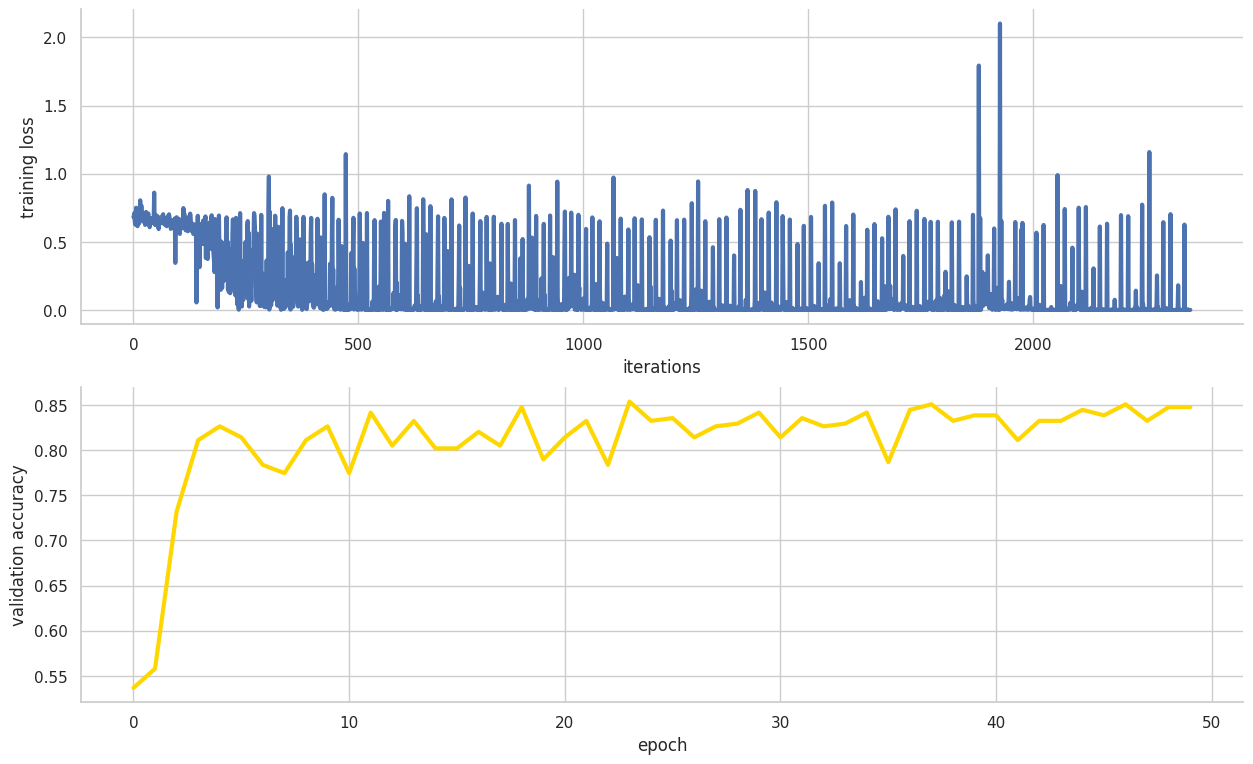

In [10]:
import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1)
# Visualize training loss

plt.figure(figsize = (15, 9))

sns.set_theme(style='whitegrid', font_scale=1)
window_size = 300  # Adjust the window size as needed
train_loss_smooth = np.convolve(train_loss_list_glitch_bg, np.ones(window_size)/window_size, mode='valid')
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(train_loss_smooth, linewidth=3)
ax.set_ylabel("training loss")
ax.set_xlabel("iterations")
ax.set_title('Glitch Background Classifier Loss')
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list_glitch_bg, linewidth = 3, color = 'gold')
plt.xlabel("epoch")
plt.ylabel("validation accuracy")
sns.despine()

In [11]:
# Save our generated model 
model_save_path = '/content/drive/MyDrive/GW/test_models/glitch_bg_model_03_003.pth'
torch.save(glitch_bg_model.state_dict(), model_save_path)